In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet, Bottleneck
from torch.quantization import fuse_modules, get_default_qconfig, prepare, convert

import os
import copy
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Data loaders
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Calibration loader for PTQ
calibrationloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

In [3]:
# Add a new argument `num_batches` with a default of None
def evaluate_model(model, dataloader, device, num_batches=None):
    """Evaluates the accuracy of a model on a given dataloader."""
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    count = 0 # <-- Add a counter
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Evaluating"):
            # --- Start of Fix ---
            if num_batches and count >= num_batches:
                break # <-- Exit loop after enough batches
            # --- End of Fix ---
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1 # <-- Increment the counter
            
    accuracy = 100 * correct / total
    return accuracy
def get_model_size(model):
    """Saves the model, gets its size, and returns the size in MB."""
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    return size_mb

def measure_latency(model, device, dummy_input):
    """Measures average inference latency of a model over 100 runs."""
    model.to(device)
    dummy_input = dummy_input.to(device)
    
    # Warm-up runs to stabilize measurements
    for _ in range(10):
        _ = model(dummy_input)
        
    # Measure latency
    latencies = []
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    for _ in range(100):
        start_time = time.time()
        _ = model(dummy_input)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000) # Convert to ms
        
    return np.mean(latencies)

In [4]:
import torchvision.models as models
from torch.quantization import QuantStub, DeQuantStub

# 1. Define a Bottleneck block that is aware of quantization
class QuantizableBottleneck(models.resnet.Bottleneck):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # FloatFunctional is used to handle operations like addition for quantized tensors
        self.add_relu = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Use the FloatFunctional for the residual addition
        out = self.add_relu.add_relu(out, identity)

        return out

# 2. Define a ResNet that uses our new Bottleneck block
class QuantizableResNet(models.ResNet):
    def __init__(self, *args, **kwargs):
        # The 'block' argument is the key to using our custom Bottleneck
        super().__init__(block=QuantizableBottleneck, *args, **kwargs)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def _forward_impl(self, x):
        x = self.quant(x)
        # Let the original ResNet forward pass run, which will now use our custom block
        x = super()._forward_impl(x)
        x = self.dequant(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)

# ... (class definitions are correct) ...

# 3. Create a factory function to build and load our model
def create_quantizable_resnet50():
    # First, create an instance of the standard ResNet50 to get its weights
    model_fp32 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # --- Start of Fix ---
    # Adapt the SOURCE model's fc layer to match the target number of classes
    num_ftrs_source = model_fp32.fc.in_features
    model_fp32.fc = nn.Linear(num_ftrs_source, 100)
    # --- End of Fix ---

    # Create our new quantizable ResNet architecture
    model_quantizable = QuantizableResNet(layers=[3, 4, 6, 3], num_classes=100)
    
    # Now that both models have an fc layer for 100 classes, the weights can be loaded.
    # The 'strict=False' is still needed for the custom Bottleneck block.
    model_quantizable.load_state_dict(model_fp32.state_dict(), strict=False)
        
    return model_quantizable

# Create the initial FP32 model using our new function
fp32_model = create_quantizable_resnet50().to(device)

In [5]:
# Fine-tuning parameters
num_epochs_finetune = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fp32_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
fp32_model.train()
for epoch in range(num_epochs_finetune):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Fine-tuning Epoch {epoch+1}/{num_epochs_finetune}")):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fp32_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}")

print("Finished Fine-tuning.")
torch.save(fp32_model.state_dict(), "resnet50_cifar100_fp32.pth")

Fine-tuning Epoch 1/10: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Epoch 1, Loss: 2.789


Fine-tuning Epoch 2/10: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]


Epoch 2, Loss: 1.926


Fine-tuning Epoch 3/10: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Epoch 3, Loss: 1.666


Fine-tuning Epoch 4/10: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s]


Epoch 4, Loss: 1.519


Fine-tuning Epoch 5/10: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]


Epoch 5, Loss: 1.398


Fine-tuning Epoch 6/10: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]


Epoch 6, Loss: 1.306


Fine-tuning Epoch 7/10: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]


Epoch 7, Loss: 1.228


Fine-tuning Epoch 8/10: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 8, Loss: 1.159


Fine-tuning Epoch 9/10: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]


Epoch 9, Loss: 1.095


Fine-tuning Epoch 10/10: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]

Epoch 10, Loss: 1.050
Finished Fine-tuning.


In [6]:
# Create a copy for quantization
ptq_model = create_quantizable_resnet50()
ptq_model.load_state_dict(torch.load("resnet50_cifar100_fp32.pth"))
ptq_model.to("cpu") # Quantization is a CPU-centric operation
ptq_model.eval()

# 1. Prepare the model with observers
# Note: Module fusion is not needed for the standard model
ptq_model.qconfig = get_default_qconfig('qnnpack')
prepare(ptq_model, inplace=True)
print("Model prepared for PTQ.")

# 2. Calibrate the model
print("Calibrating model...")
# Pass the num_batches argument to limit calibration to 200 batches
evaluate_model(ptq_model, calibrationloader, torch.device("cpu"), num_batches=200)
print("Calibration complete.")

# 3. Convert to a quantized model
int8_model_ptq = convert(ptq_model)
print("Model converted to INT8.")
del ptq_model

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_18280\458163898.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepare(ptq_model, inplace=True)


Model prepared for PTQ.
Calibrating model...


Evaluating:  13%|█▎        | 200/1563 [00:46<05:20,  4.26it/s]
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_18280\458163898.py:20: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  int8_model_ptq = convert(ptq_model)


Calibration complete.
Model converted to INT8.


Evaluating FP32 model accuracy on GPU...


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]



Evaluating INT8 PTQ model accuracy on CPU...


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]



Measuring model sizes...

Measuring latencies...

--- Model Comparison ---
FP32 Model Accuracy: 59.22%
INT8 PTQ Model Accuracy: 56.63%
-------------------------
FP32 Model Size: 95.15 MB
INT8 PTQ Model Size: 24.24 MB
-------------------------
FP32 (GPU) Avg. Latency: 14.10 ms
INT8 (CPU) Avg. Latency: 79.55 ms
-------------------------


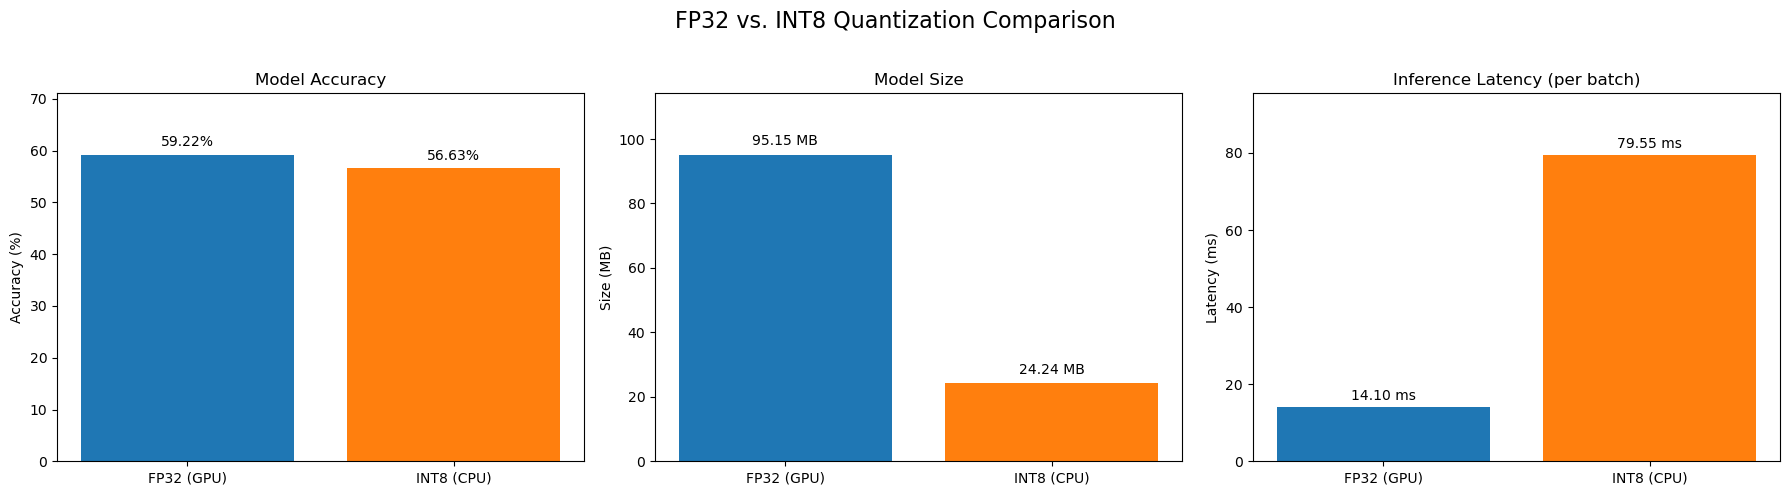

In [7]:
# --- Step 1: Define Devices ---
gpu_device = torch.device("cuda:0")
cpu_device = torch.device("cpu")

# --- Step 2: Evaluate Accuracy ---
print("Evaluating FP32 model accuracy on GPU...")
fp32_model.to(gpu_device).eval()
fp32_accuracy = evaluate_model(fp32_model, testloader, gpu_device)

print("\nEvaluating INT8 PTQ model accuracy on CPU...")
int8_model_ptq.to(cpu_device).eval()
int8_ptq_accuracy = evaluate_model(int8_model_ptq, testloader, cpu_device)

# --- Step 3: Measure Model Size ---
print("\nMeasuring model sizes...")
fp32_size = get_model_size(fp32_model.to(cpu_device))
int8_size = get_model_size(int8_model_ptq)

# --- Step 4: Measure Latency ---
print("\nMeasuring latencies...")
dummy_input, _ = next(iter(testloader))
fp32_latency = measure_latency(fp32_model, gpu_device, dummy_input)
int8_latency = measure_latency(int8_model_ptq, cpu_device, dummy_input)

# --- Step 5: Print Summary ---
print("\n--- Model Comparison ---")
print(f"FP32 Model Accuracy: {fp32_accuracy:.2f}%")
print(f"INT8 PTQ Model Accuracy: {int8_ptq_accuracy:.2f}%")
print("-" * 25)
print(f"FP32 Model Size: {fp32_size:.2f} MB")
print(f"INT8 PTQ Model Size: {int8_size:.2f} MB")
print("-" * 25)
print(f"FP32 (GPU) Avg. Latency: {fp32_latency:.2f} ms")
print(f"INT8 (CPU) Avg. Latency: {int8_latency:.2f} ms")
print("-" * 25)

# --- Step 6: Plotting the Results ---
labels = ['FP32 (GPU)', 'INT8 (CPU)']
accuracies = [fp32_accuracy, int8_ptq_accuracy]
sizes = [fp32_size, int8_size]
latencies = [fp32_latency, int8_latency]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('FP32 vs. INT8 Quantization Comparison', fontsize=16)

# Plot Accuracy
bars1 = ax1.bar(labels, accuracies, color=['#1f77b4', '#ff7f0e'])
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Model Accuracy')
ax1.set_ylim(0, max(accuracies) * 1.2)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Plot Model Size
bars2 = ax2.bar(labels, sizes, color=['#1f77b4', '#ff7f0e'])
ax2.set_ylabel('Size (MB)')
ax2.set_title('Model Size')
ax2.set_ylim(0, max(sizes) * 1.2)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f} MB', ha='center', va='bottom')

# Plot Latency
bars3 = ax3.bar(labels, latencies, color=['#1f77b4', '#ff7f0e'])
ax3.set_ylabel('Latency (ms)')
ax3.set_title('Inference Latency (per batch)')
ax3.set_ylim(0, max(latencies) * 1.2)
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f} ms', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()